#  Quantization aware (QKeras) GraphConv Neural Network for Jet tagging using jet constituents from HLS data using CONV1D layers on fully conected graphs

## Author: Andre Sznajder

 

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'


# Load HLS4ML dataset 

## Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

## https://github.com/pierinim/tutorials/blob/master/GGI_Jan2021/Lecture1/Notebook1_ExploreDataset.ipynb

 * 'jetImage' contains the image representation of the jets (more later)

 * 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)

 * 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored

 * 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList' 'jets' is the dataset we consider for the moment

 * 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'


In [3]:
import numpy as np
import h5py
import os

# for pT, eta_rel, phi_rel
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
# for px, py, pz
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
#   myJetConstituentList = np.array(f.get("jetConstituentList"))
#
# Jet Constituents Features =  [0='j1_px', 1='j1_py', 2='j1_pz', 3='j1_e', 4='j1_erel', 5='j1_pt', 6='j1_ptrel',
#                         7='j1_eta', 8='j1_etarel', 9='j1_etarot', 10='j1_phi', 11='j1_phirel', 12='j1_phirot',
#                         13='j1_deltaR', 14='j1_costheta', 15='j1_costhetarel', 16='j1_pdgid']



#Data PATH
TRAIN_PATH = '/Users/sznajder/WorkM1/workdir/data/hls4ml_LHCjet_150p_train/'

# Prepare the DATA
#target = np.array([])
#jetConstituent = np.array([])
#jetImage = np.array([])

first=True
for file in os.listdir(TRAIN_PATH):
  print("Appending %s" %file)

  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
#        jetImage= data['jetImage'][:,:,:] 
        target = data['jets'][:,-6:-1]
    
        print("Keys in H5PY files = ",list( data.keys() ))
        print(" ")
        featurenames = data.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        # the b is due to the byte vs utf-8 encoding of the strings in the dataset
        # just ignore them for the moment
        print(" ")
        featurenames = data.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = data.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")

    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
         # Read (Pt,Eta,Phi)
#        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,7,10]] ] , axis=0 )
#        jetImage = np.concatenate( [ jetImage, data['jetImage']    ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )

                                    
print("Target shape =", target.shape)
print("Jet Constituents shape =", jetConstituent.shape)
#print("Jet Image shape =", jetImage.shape)


Appending jetImage_6_150p_40000_50000.h5
Keys in H5PY files =  ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
 
Jets Features =  [b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'

# The image dataset

Jets can be converted to images considering the (&eta;, &phi;) plane, centered along the axis direction and binned.
In our case, we consider a square of 1.6x1.6 in size (because the jet size is R=0.8) binned in 100x100 equal-size 'cells'


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



In [4]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# 1st dim is jet image index
# 2nd dim is image eta bin
# 3rd dim is image phi bin
njet = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat = jetConstituent.shape[2]

print('Shape of jetConstituent =',jetConstituent.shape)
print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

# Filter out constituents with Pt<2GeV
Ptmin =2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1


# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]

del constituents

# Restric the number of constituents to a maximum of NMAX
nmax = 8
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]

print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)


Shape of jetConstituent = (620000, 150, 3)
Number of jets = 620000
Number of constituents = 150
Number of features = 3
Number of jets = 620000
Number of constituents = 8
Number of features = 3
Pt order of jetConstituent before shuffling = [118.65741  113.409935 113.007545 104.92594   61.50102   53.66348
  45.74336   39.23477 ]
Before --->> jetConstituent[0,0:4,0] =  [118.65741  113.409935 113.007545 104.92594 ]
After --->> jetConstituent[0,0:4,0] =  [ 53.66348   45.74336  118.65741  113.007545]
Pt order of jetConstituent after shuffling = [ 53.66348   45.74336  118.65741  113.007545  39.23477   61.50102
 113.409935 104.92594 ]


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [5]:
from sklearn.model_selection import train_test_split

X = jetConstituent
Y = target
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

del jetConstituent
del target 

#print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of Z jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))

print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of Z jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))





number of G jets for training/validation: 83689
number of Q jets for training/validation: 80676
number of W jets for training/validation: 83507
number of Z jets for training/validation: 83589
number of T jets for training/validation: 83939
number of G jets for testing: 41159
number of Q jets for testing: 39535
number of W jets for testing: 41430
number of Z jets for testing: 41065
number of T jets for testing: 41411


## Define a GraphConv NN by applaying a convolutional layer (Conv1D) over each node of a fully connected Graph. Weights of  convolutional filter ( kernel ) are shared across the nodes by using a convolution sliding window of the size of the node features vector (kernel size) and a stride equal to the kernel size. 

### OBS: this Conv1D approach is equivalent to applying a a given MLP to each node individually and then aggregating the outputs

In [6]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Flatten 
from tensorflow.keras import utils
from qkeras import *

###########################################################################
# Define GraphConv Model 

'''
# For 32 constituents
point_channels=18   
nhidden = int(nconstit*nfeat/12.)              
'''

'''
# For 16 constituents
point_channels=16                  
nhidden = int(nconstit*nfeat/3.) 
'''

#'''
# For 8 constituents
point_channels = 20    
nhidden = int(nconstit*nfeat) 
#'''


# Number of target classes
ntargets = len(Y_train_val[0]) 



# Quantized bits
nbits=4
qbits = quantized_bits(nbits,0,alpha=1.0)
qact = 'quantized_relu('+str(nbits)+',0)'


# Print
print("Trainign with max # of contituents = ", nconstit)
print("Number of node features = ", nfeat)
print("Quantization with nbits=",nbits)

#############################################################################

'''
# Conv1D with kernel_size=nfeatures and strides=nfeatures to implement a MLP like aggregation of 
#   input point features ( pt, eta_rel, phi_rel)
h = QConv1D(point_channels, kernel_size=nfeat, strides=nfeat
                  , activation="relu"
                  , use_bias="True"
                  , name='Conv1D_points')(h)
'''



##############################################################################

# Instantiate Tensorflow input tensors in Batch mode 
#inp = Input(shape=(nconstit,nfeat), name="input")   # Conv1D input format
inp = Input(shape=(1,nconstit,nfeat), name="input")    # Conv2D input format


# Input point features BatchNormalization 
h = BatchNormalization(name='BatchNorm')(inp)

# Conv1D with kernel_size=1 and stride=1 to implement a MLP like aggregation of 
#   input point features ( pt, eta_rel, phi_rel)
#h  = QConv1D(point_channels, kernel_size=1, strides=1, name='Conv1D',
#             kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="True" )(h)
h  = QConv2D(point_channels, kernel_size=(1,1), strides=(1,1), name='Conv1D',
             kernel_quantizer=qbits, bias_quantizer=qbits, use_bias="True" )(h)


h = QActivation( activation = qact, name = 'activation_conv')(h)

# Flatten for MLP input
h=Flatten(name='Flatten')(h)

# Dense layers for classification
h = QDense(nhidden, name='Dense1', kernel_quantizer=qbits, bias_quantizer=qbits )(h)

h = QActivation( activation = qact, name = 'activation_dense')(h)

out = QDense(ntargets, name='Dense2', kernel_quantizer=qbits, bias_quantizer=qbits )(h)  # (N, num_classes)

out = Activation("softmax", name="softmax")(out)

# Build the model
model = Model(inputs=inp, outputs=out)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0001,decay=1e-6)
optim = Adam(learning_rate=0.0005)
#optim = Adam(learning_rate=0.0002)
#optim = Adam()


# Compile the Model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()



Trainign with max # of contituents =  8
Number of node features =  3
Quantization with nbits= 4
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 8, 3)]         0         
_________________________________________________________________
BatchNorm (BatchNormalizatio (None, 1, 8, 3)           12        
_________________________________________________________________
Conv1D (QConv2D)             (None, 1, 8, 20)          80        
_________________________________________________________________
activation_conv (QActivation (None, 1, 8, 20)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
Dense1 (QDense)              (None, 24)                3864      
_______________________________

## Run training
Here, we run the training.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=5)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('QGraphConv_model.h5', monitor='val_categorical_accuracy', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

# Train classifier
print("X_train_val before expandims=",X_train_val.shape)
X_train_val = tf.expand_dims(X_train_val,axis=1)  # Reshape tensor for using Conv2D
print("X_train_val after expanddims=",X_train_val.shape)


history = model.fit(  X_train_val , Y_train_val, 
                    epochs=100, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls], 
                    validation_split=0.3 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 
 
# Save the model
model.save('model_QGraphConv2D_nconst_'+str(nmax)+'_nbits_'+str(nbits)+'.h5')

X_train_val before expandims= (415400, 8, 3)
X_train_val after expanddims= (415400, 1, 8, 3)
Epoch 1/100
568/568 [==============================] - 1s 2ms/step - loss: 1.3344 - categorical_accuracy: 0.4462 - val_loss: 1.2856 - val_categorical_accuracy: 0.4707
Epoch 2/100
568/568 [==============================] - 1s 2ms/step - loss: 1.2028 - categorical_accuracy: 0.5105 - val_loss: 1.1798 - val_categorical_accuracy: 0.5066
Epoch 3/100
568/568 [==============================] - 1s 2ms/step - loss: 1.1626 - categorical_accuracy: 0.5295 - val_loss: 1.1446 - val_categorical_accuracy: 0.5422
Epoch 4/100
568/568 [==============================] - 1s 2ms/step - loss: 1.1387 - categorical_accuracy: 0.5417 - val_loss: 1.1276 - val_categorical_accuracy: 0.5511
Epoch 5/100
568/568 [==============================] - 1s 2ms/step - loss: 1.1241 - categorical_accuracy: 0.5493 - val_loss: 1.1178 - val_categorical_accuracy: 0.5550
Epoch 6/100
568/568 [==============================] - 1s 2ms/step - los

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

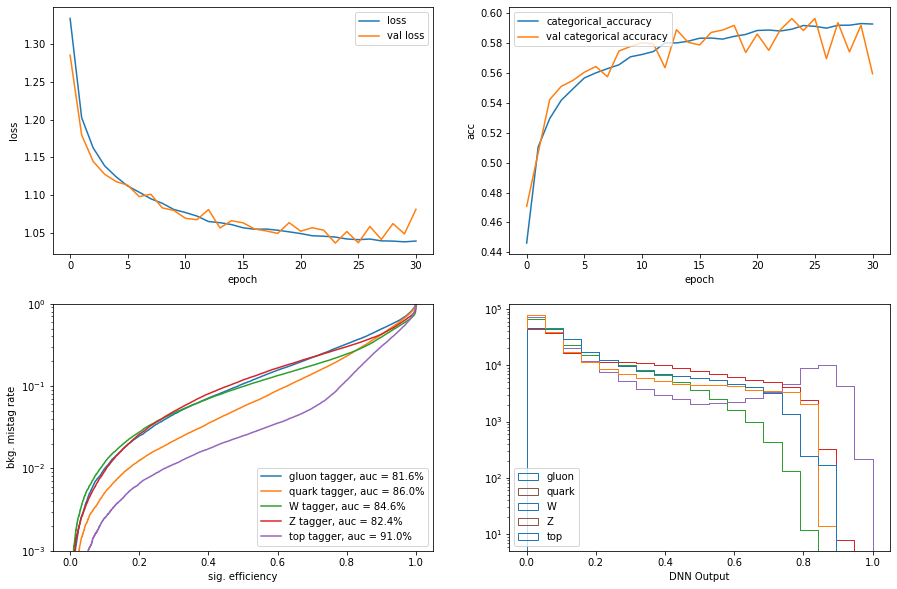

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
ax = plt.subplot(2, 2, 3)
X_test = tf.expand_dims(X_test,axis=1)  # Reshape tensor for using Conv2D
Y_predict = model.predict(X_test)
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve(Y_test[:,i], Y_predict[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')
# Display plots
plt.show()


In [9]:

# Save FPR for a given TPR value ( 30% , 50% & 80%)
model = 'QGraphConv'
with open('performance_'+model+'_nconst_'+str(nmax)+'_nbits_'+str(nbits)+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( model+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
 

Label =  gluon  with treshold =  0.3
TPR =  0.3000072888068223
FPR =  0.045441474293475934
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000121480113705
FPR =  0.10638089585844433
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000194368181929
FPR =  0.32513261666289367
 
Label =  quark  with treshold =  0.3
TPR =  0.30003794106487924
FPR =  0.02166419289370854
 
Label =  quark  with treshold =  0.5
TPR =  0.5000126470216264
FPR =  0.056408081664798715
 
Label =  quark  with treshold =  0.8
TPR =  0.8000252940432528
FPR =  0.23114530639445066
 
Label =  W  with treshold =  0.3
TPR =  0.3000241370987207
FPR =  0.047226818655390086
 
Label =  W  with treshold =  0.5
TPR =  0.5000482741974415
FPR =  0.09890298461727033
 
Label =  W  with treshold =  0.8
TPR =  0.8000241370987208
FPR =  0.24564564564564564
 
Label =  Z  with treshold =  0.3
TPR =  0.30001217581882383
FPR =  0.0492004769621182
 
Label =  Z  with treshold =  0.5
TPR =  0.5000121758188238
FPR =  0.11880637172470725
 
Labe